# Inverse distance weighting - Crimes Dataset

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html

https://medium.com/@mattheweparker/visualizing-data-with-hexbins-in-python-39823f89525e

## Importing packages and loading necessary datasets

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


In [3]:
crimes_df = pd.read_csv("Data/crimes_processed_vehicle.csv")

In [4]:
display(crimes_df)

Latitude  Longitude  Community Area  n  location_id
0      41.644590 -87.615880              54  1            1
1      41.647037 -87.616647              54  1            2
2      41.647039 -87.616098              54  2            3
3      41.647180 -87.544241              55  1            4
4      41.647716 -87.542811              55  1            5
...          ...        ...             ... ..          ...
25463  42.022526 -87.672401               1  1        25464
25464  42.022529 -87.666324               1  1        25465
25465  42.022535 -87.673398               1  2        25466
25466  42.022536 -87.673711               1  1        25467
25467  42.022548 -87.676139               1  1        25468

[25468 rows x 5 columns]

## Splitting Data

In [21]:
# Convert columns to numpy arrays
observed_location_columns_crimes = ['Longitude','Latitude', 'Community Area']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

In [22]:
X_train_crimes, X_test_crimes, y_train_crimes, y_test_crimes = train_test_split(observed_locations_crimes,
                                                                            observed_values_crimes, test_size=0.2, random_state=0)
print(f"X_train_meuse.shape: {X_train_crimes.shape}")
print(f"X_test_meuse.shape:  {X_test_crimes.shape}")
print(f"y_train_meuse.shape: {y_train_crimes.shape}")
print(f"y_test_meuse.shape:  {y_test_crimes.shape}")

X_train_meuse.shape: (20374, 3)
X_test_meuse.shape:  (5094, 3)
y_train_meuse.shape: (20374,)
y_test_meuse.shape:  (5094,)


## Understanding distribution of clusters in train and test sets

In [23]:
x_values = [element[0] for element in X_train_crimes]
y_values = [element[1] for element in X_train_crimes]
cluster_values = [element[2] for element in X_train_crimes]

data = {
    'x': x_values,
    'y': y_values,
    'cluster_num': cluster_values
}

train_df = pd.DataFrame(data)
train_df['cluster_num'] = train_df['cluster_num'].astype('category')

x_values_test = [element[0] for element in X_test_crimes]
y_values_test = [element[1] for element in X_test_crimes]
cluster_values_test = [element[2] for element in X_test_crimes]

data_test  = {
    'x': x_values_test,
    'y': y_values_test,
    'cluster_num': cluster_values_test
}

test_df = pd.DataFrame(data_test)
test_df['cluster_num'] = test_df['cluster_num'].astype('category')

In [24]:
train_df.describe(include='all')

x             y  cluster_num
count   20374.000000  20374.000000      20374.0
unique           NaN           NaN         77.0
top              NaN           NaN         25.0
freq             NaN           NaN       1040.0
mean      -87.668161     41.838820          NaN
std         0.058705      0.088524          NaN
min       -87.915105     41.644590          NaN
25%       -87.709835     41.763552          NaN
50%       -87.665208     41.846372          NaN
75%       -87.625739     41.906646          NaN
max       -87.525748     42.022536          NaN

<Axes: >

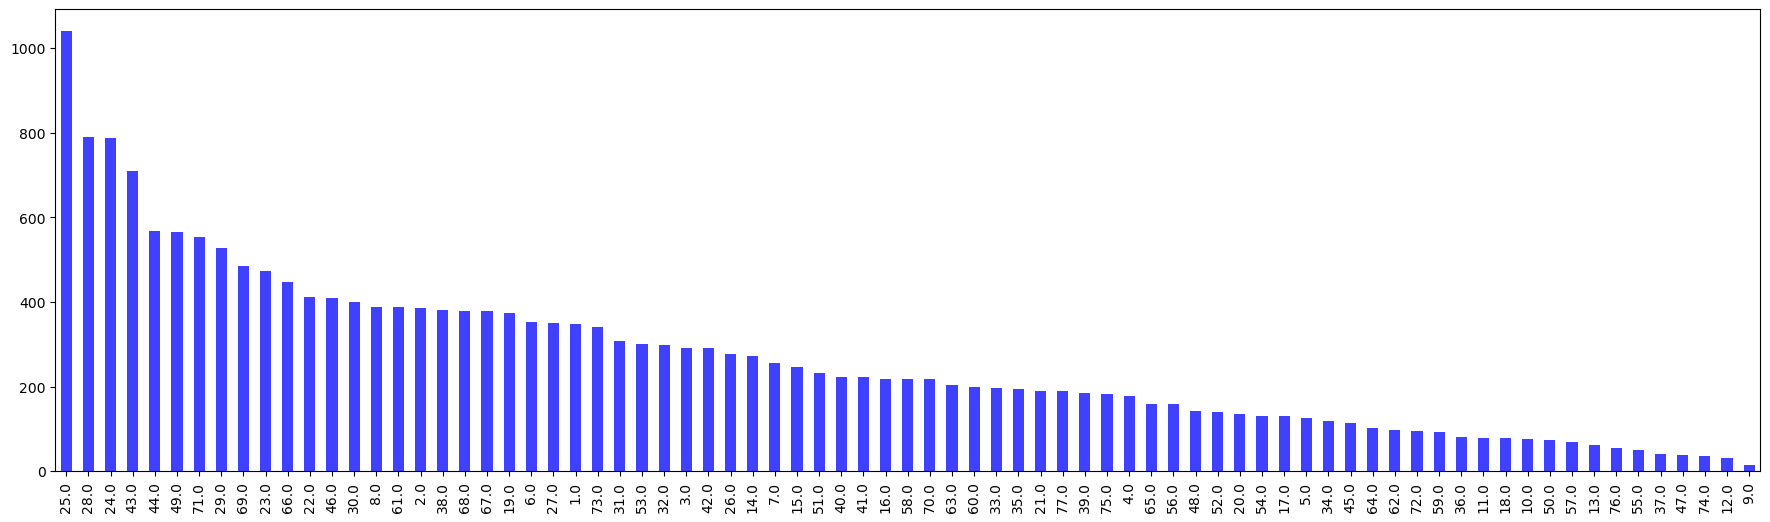

In [25]:
# Count the occurrences of each category
category_counts = train_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue', figsize=(22, 6))

In [26]:
test_df.describe(include='all')

x            y  cluster_num
count   5094.000000  5094.000000       5094.0
unique          NaN          NaN         77.0
top             NaN          NaN         25.0
freq            NaN          NaN        278.0
mean     -87.668812    41.838853          NaN
std        0.058717     0.088203          NaN
min      -87.906547    41.647716          NaN
25%      -87.710435    41.764212          NaN
50%      -87.665034    41.847612          NaN
75%      -87.625856    41.907087          NaN
max      -87.525270    42.022548          NaN

<Axes: >

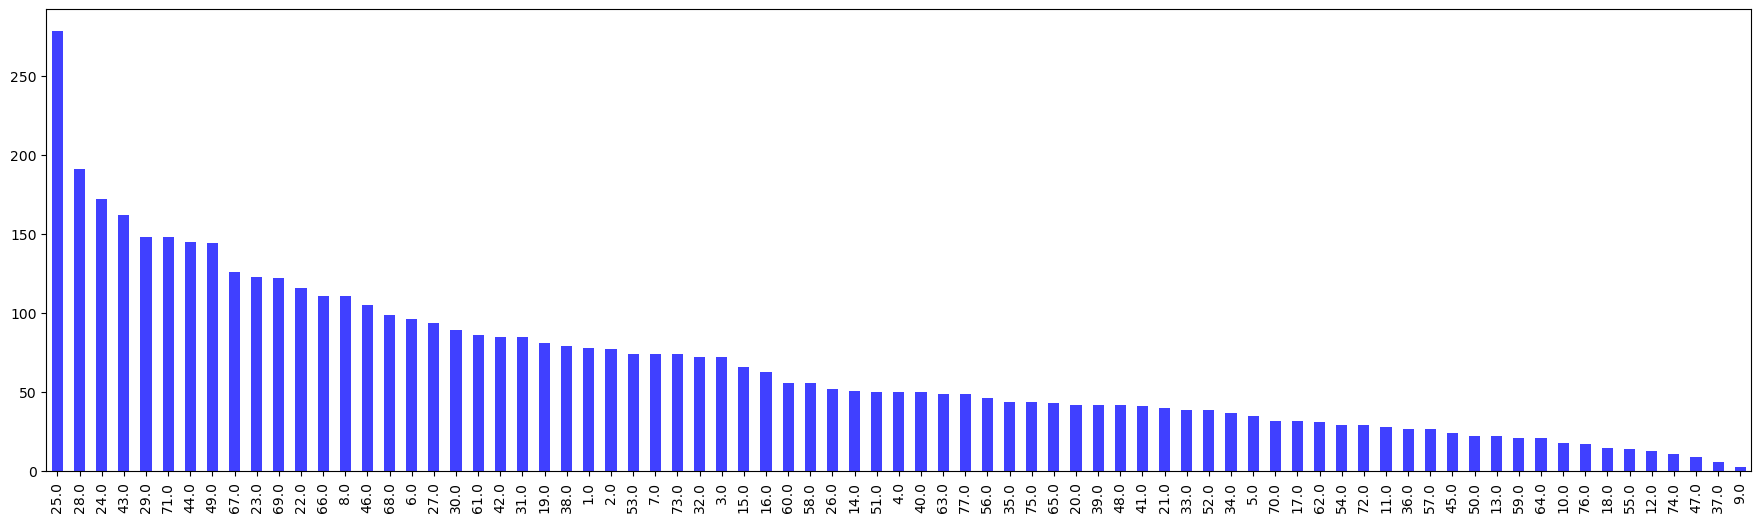

In [27]:
# Count the occurrences of each category
category_counts = test_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue', figsize=(22, 6))

## Spatial K-Fold Cross Validation

In [28]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_crimes]
y_data_train = [inner_list[1] for inner_list in X_train_crimes]
cluster_num_data_train = [inner_list[2] for inner_list in X_train_crimes]

In [62]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'cluster_num':cluster_num_data_train,
    'Z': y_train_crimes
})

# Initialize an empty dictionary
cv_score_list = {}
powers_list = [1,2,3,4,5,6,7,8]

start_time = time.time()
#For each possible theoratical model, conduct K-Fold CV
for power in powers_list:
    
    
    # Define K-Fold cross-validation
    group_kfold = GroupKFold(n_splits = 5)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []

    # Perform K-Fold cross-validation
    for train_index, test_index in group_kfold.split(cv_data['X'],cv_data['Y'],cv_data['cluster_num']):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = power)
        
        # Calculate Metrics and append the validation score for each split into cv_scores_metric
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        r2 = r2_score(test_data['Z'], z_pred_train)
        
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        
    # Calulcate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    
    # Store the mean CV score for each metric for this iteration of theoratical model chosen
    cv_score_list[power] = {
        "Mean CV Score MAE" : mean_validation_score_mae,
        "Mean CV Score RMSE" : mean_validation_score_rmse,
        "Mean CV Score MAPE" : mean_validation_score_mape,
        "Mean CV Score R Squared": mean_validation_score_r2
    }

end_time = time.time()
# Now there is a dictionary of mean CV scores for 3 different metrics for each possible model 
display(pd.DataFrame(cv_score_list))

# Find the model with the smallest mean CV score for each metric
# Initialize a dictionary to track the smallest scores and corresponding models
smallest_scores = {
    "Mean CV Score MAE": {"value": float('inf'), "power": None},
    "Mean CV Score RMSE": {"value": float('inf'), "power": None},
    "Mean CV Score MAPE": {"value": float('inf'), "power": None},
    "Mean CV Score R Squared": {"value": float('-inf'), "power": None}
}
    
# Iterate through each model's scores in the dictionary
for power, scores in cv_score_list.items():
    for score_type, score_value in scores.items():
        # Special handling for R Squared to find the maximum
        if score_type == "Mean CV Score R Squared":
            if score_value > smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["power"] = power
        # For all other metrics, we find the minimum
        else:
            if score_value < smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["power"] = power

# Display the results
for score_type, info in smallest_scores.items():
    if score_type == "Mean CV Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['power']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['power']}.")
    
print(f"Training Computation Time: {end_time - start_time:.2f} seconds")

1         2         3         4         5  \
Mean CV Score MAE        0.394796  0.395765  0.397220  0.398567  0.399667   
Mean CV Score RMSE       0.937884  0.946607  0.959332  0.972922  0.985493   
Mean CV Score MAPE       0.268762  0.269910  0.271242  0.272389  0.273250   
Mean CV Score R Squared -0.129285 -0.150038 -0.179667 -0.211737 -0.242332   

                                6         7         8  
Mean CV Score MAE        0.400534  0.401189  0.401650  
Mean CV Score RMSE       0.996564  1.006191  1.014526  
Mean CV Score MAPE       0.273856  0.274258  0.274495  
Mean CV Score R Squared -0.270115 -0.294892 -0.316804

The smallest Mean CV Score MAE is 0.39479604276323804, found in power 1.
The smallest Mean CV Score RMSE is 0.9378838359604496, found in power 1.
The smallest Mean CV Score MAPE is 0.2687621391332248, found in power 1.
The largest Mean CV Score R Squared is -0.12928485135974999, found in power 1.
Training Computation Time: 6.59 seconds


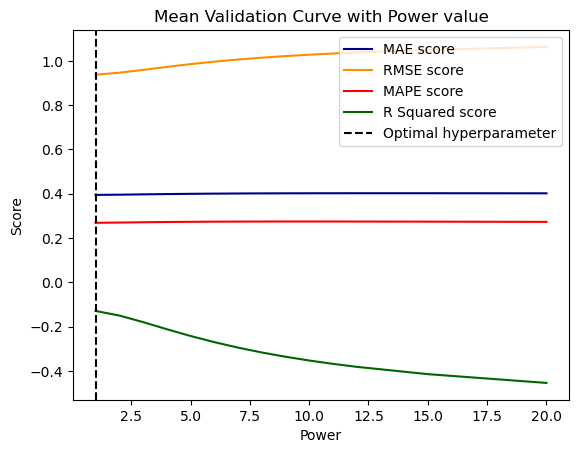

In [35]:
power = 1
df = pd.DataFrame(cv_score_list).T
plt.plot(powers_list, df["Mean CV Score MAE"], color='darkblue', label='MAE score')
plt.plot(powers_list, df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(powers_list, df["Mean CV Score MAPE"], color='red', label='MAPE score')
plt.plot(powers_list, df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(power, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('Power')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.title("Mean Validation Curve with Power value")
plt.show()

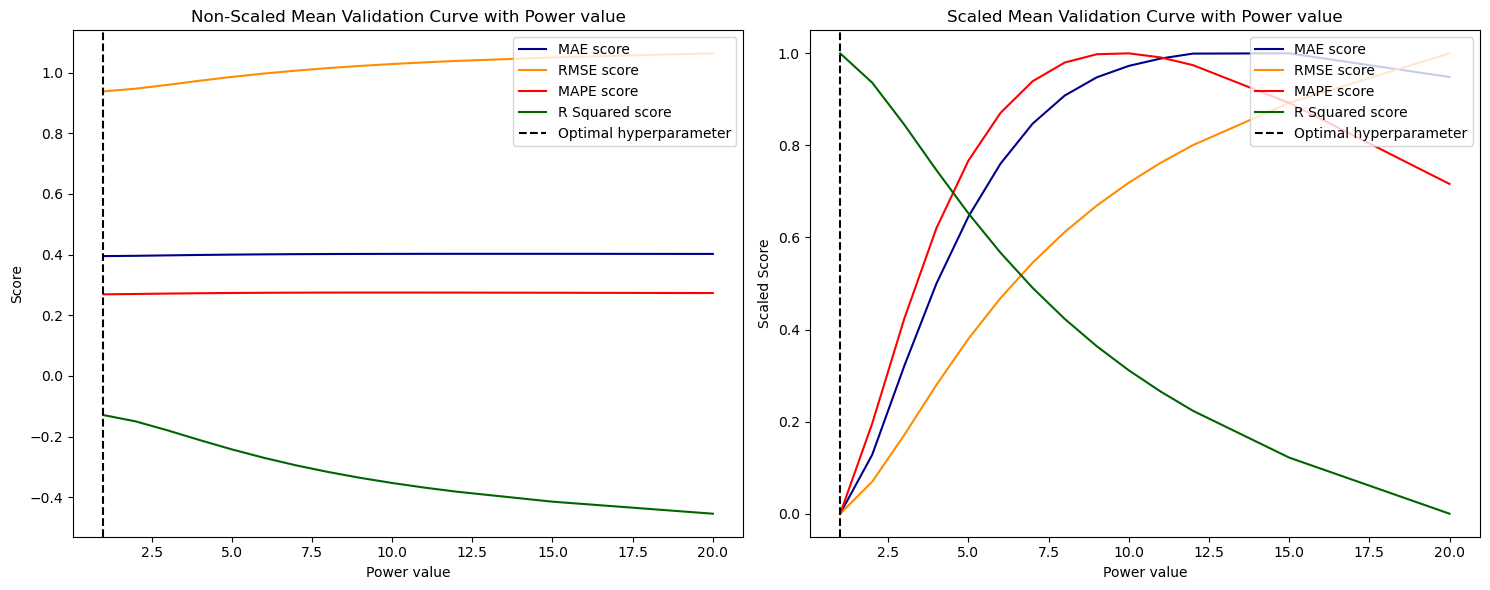

In [36]:
df = pd.DataFrame(cv_score_list).T
power = 1
# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Mean CV Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Mean CV Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Mean Validation Curve with Power value")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Mean CV Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Mean CV Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Mean Validation Curve with Power value")

plt.tight_layout()
plt.show()

### n_neighbors

In [74]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'cluster_num':cluster_num_data_train,
    'Z': y_train_crimes
})

# Initialize an empty dictionary
cv_score_list = {}

# For each possible number of neighbors, conduct K-Fold CV
n_neighbors_list = np.arange(240,301,3)

start_time = time.time()

for n_neighbors in n_neighbors_list:
    
    # Define K-Fold cross-validation
    group_kfold = GroupKFold(n_splits = 5)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []

    # Perform K-Fold cross-validation
    for train_index, test_index in group_kfold.split(cv_data['X'],cv_data['Y'],cv_data['cluster_num']):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = 1, n_neighbors = n_neighbors)
        
        # Calculate Metrics
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        r2 = r2_score(test_data['Z'], z_pred_train)
        
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        
    # Calculate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    
    
    # Store the mean CV score for each metric for this iteration of n_neighbors chosen
    cv_score_list[n_neighbors] = {
        "Mean CV Score MAE": mean_validation_score_mae,
        "Mean CV Score RMSE": mean_validation_score_rmse,
        "Mean CV Score MAPE": mean_validation_score_mape,
        "Mean CV Score R Squared": mean_validation_score_r2
    }
end_time = time.time()

# Display the results
display(pd.DataFrame(cv_score_list))  # Transposed for better readability

# Find the model with the smallest mean CV score for each metric
# Adjusted to find the best `n_neighbors`    
smallest_scores = {
    "Mean CV Score MAE": {"value": float('inf'), "model": None},
    "Mean CV Score RMSE": {"value": float('inf'), "model": None},
    "Mean CV Score MAPE": {"value": float('inf'), "model": None},
    "Mean CV Score R Squared": {"value": float('-inf'), "model": None} # Changed to '-inf' for maximization
}

# Iterate through each model's scores in the dictionary
for n_neighbors, scores in cv_score_list.items():
    for score_type, score_value in scores.items():
        # Special handling for R Squared to find the maximum
        if score_type == "Mean CV Score R Squared":
            if score_value > smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["n_neighbors"] = n_neighbors
        # For all other metrics, we find the minimum
        else:
            if score_value < smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["n_neighbors"] = n_neighbors

# Display the results
for score_type, info in smallest_scores.items():
    if score_type == "Mean CV Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['n_neighbors']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['n_neighbors']}.")
        
print(f"Training Computation Time: {end_time - start_time:.2f} seconds")

240       243       246       249       252  \
Mean CV Score MAE        0.368280  0.368294  0.368299  0.368299  0.368282   
Mean CV Score RMSE       0.878256  0.878278  0.878284  0.878294  0.878276   
Mean CV Score MAPE       0.241998  0.241998  0.241991  0.241986  0.241954   
Mean CV Score R Squared  0.011671  0.011625  0.011605  0.011602  0.011649   

                              255       258       261       264       267  \
Mean CV Score MAE        0.368294  0.368299  0.368234  0.368241  0.368233   
Mean CV Score RMSE       0.878247  0.878267  0.878258  0.878244  0.878256   
Mean CV Score MAPE       0.241964  0.241959  0.241894  0.241890  0.241882   
Mean CV Score R Squared  0.011736  0.011703  0.011749  0.011830  0.011807   

                         ...       273       276       279       282  \
Mean CV Score MAE        ...  0.368166  0.368154  0.368132  0.368125   
Mean CV Score RMSE       ...  0.878234  0.878194  0.878199  0.878238   
Mean CV Score MAPE       ...  0.241809  0.241792  0.241753  0.241728   
Mean CV Score R Squared  ...  0.011885  0.011984  0.012009  0.011926   

                              285       288       291       294       297  \
Mean CV Score MAE        0.368106  0.368069  0.368090  0.368068  0.368040   
Mean CV Score RMSE       0.878209  0.878233  0.878315  0.878356  0.878324   
Mean CV Score MAPE       0.241696  0.241646  0.241651  0.241617  0.241580   
Mean CV Score R Squared  0.011991  0.011952  0.011781  0.011711  0.011783   

                              300  
Mean CV Score MAE        0.368045  
Mean CV Score RMSE       0.878345  
Mean CV Score MAPE       0.241570  
Mean CV Score R Squared  0.011733  

[4 rows x 21 columns]

The smallest Mean CV Score MAE is 0.36803998492988343, found in n_neighbors 297.
The smallest Mean CV Score RMSE is 0.8781937590611679, found in n_neighbors 276.
The smallest Mean CV Score MAPE is 0.24157032699673203, found in n_neighbors 300.
The largest Mean CV Score R Squared is 0.012008735649019497, found in n_neighbors 279.
Training Computation Time: 32.91 seconds


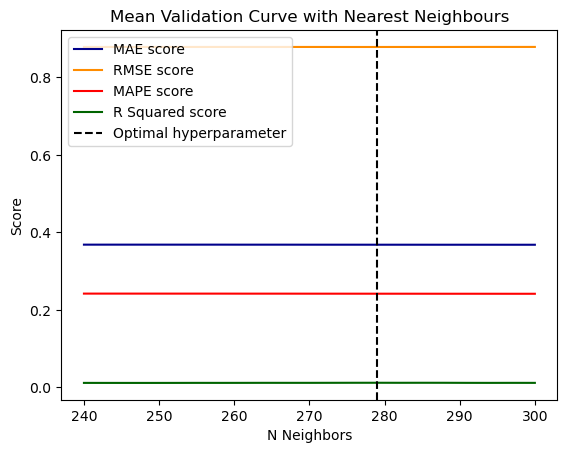

In [78]:
n_neighbors = 279
df = pd.DataFrame(cv_score_list).T
plt.plot(n_neighbors_list, df["Mean CV Score MAE"], color='darkblue', label='MAE score')
plt.plot(n_neighbors_list, df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(n_neighbors_list, df["Mean CV Score MAPE"], color='red', label='MAPE score')
plt.plot(n_neighbors_list, df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(n_neighbors, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('N Neighbors')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.title("Mean Validation Curve with Nearest Neighbours")
plt.show()

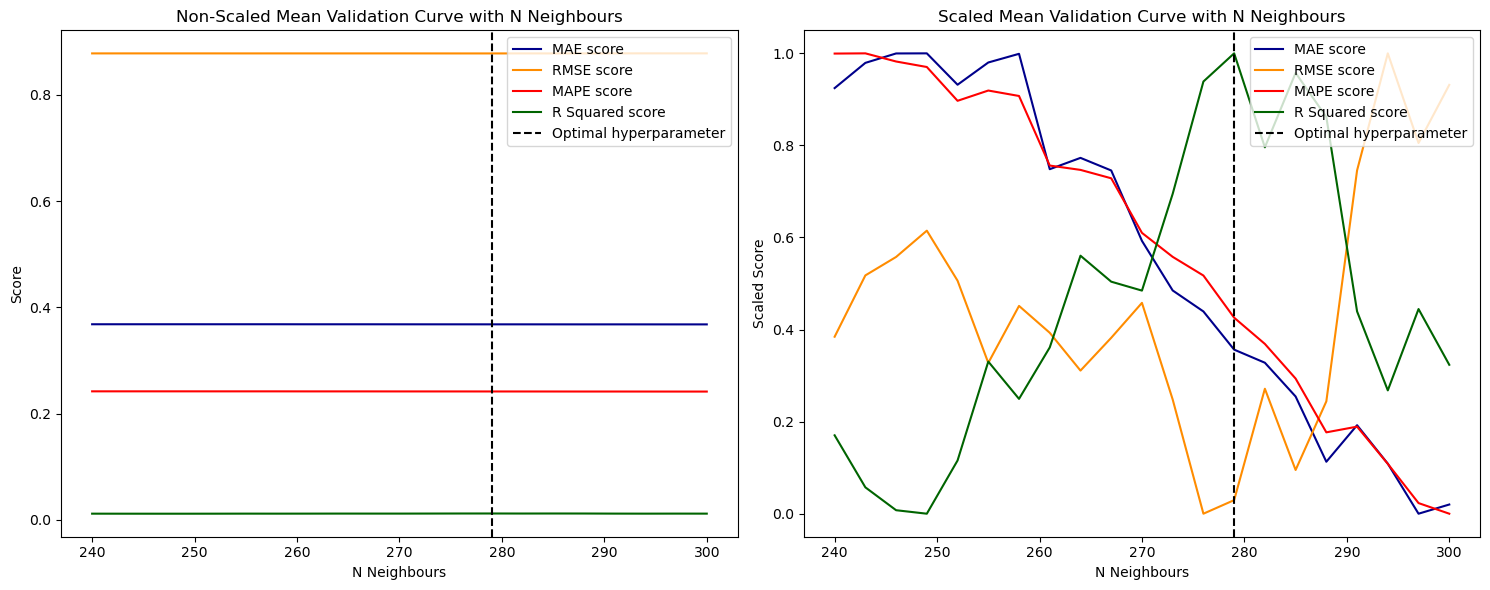

In [77]:
df = pd.DataFrame(cv_score_list).T
n_neighbors = 279
# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Mean CV Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Mean CV Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbours')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Mean Validation Curve with N Neighbours")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Mean CV Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Mean CV Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbours')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Mean Validation Curve with N Neighbours")

plt.tight_layout()
plt.show()

## Hyperparameter selection

## Evaluation of Model (Testing Chosen model)

### Performance Metrics of Model

In [79]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_crimes]
y_data_train = [inner_list[1] for inner_list in X_train_crimes]

train_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_crimes
})

x_data_test = [inner_list[0] for inner_list in X_test_crimes]
y_data_test = [inner_list[1] for inner_list in X_test_crimes]

test_data = pd.DataFrame({
    'X': x_data_test,
    'Y': y_data_test,
    'Z': y_test_crimes
})

eval_combined_array_coordinates = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])

start_time = time.time()
idw_model = ShepardIDWInterpolator(eval_combined_array_coordinates, train_data['Z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
z_pred_test = idw_model.__call__(eval_combined_array_test, power = 1, n_neighbors = 279)

rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_test))
mae = mean_absolute_error(test_data['Z'], z_pred_test)
mape = mean_absolute_percentage_error(test_data['Z'], z_pred_test)
r2 = r2_score(test_data['Z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.3627282990667856
RMSE: 0.9014895063800853
MAPE: 0.23587847991290947
R Squared: 0.04257465719855169
Testing Computation Time: 0.32 seconds


### Plotting Spatial Interpolation of entire area with Model

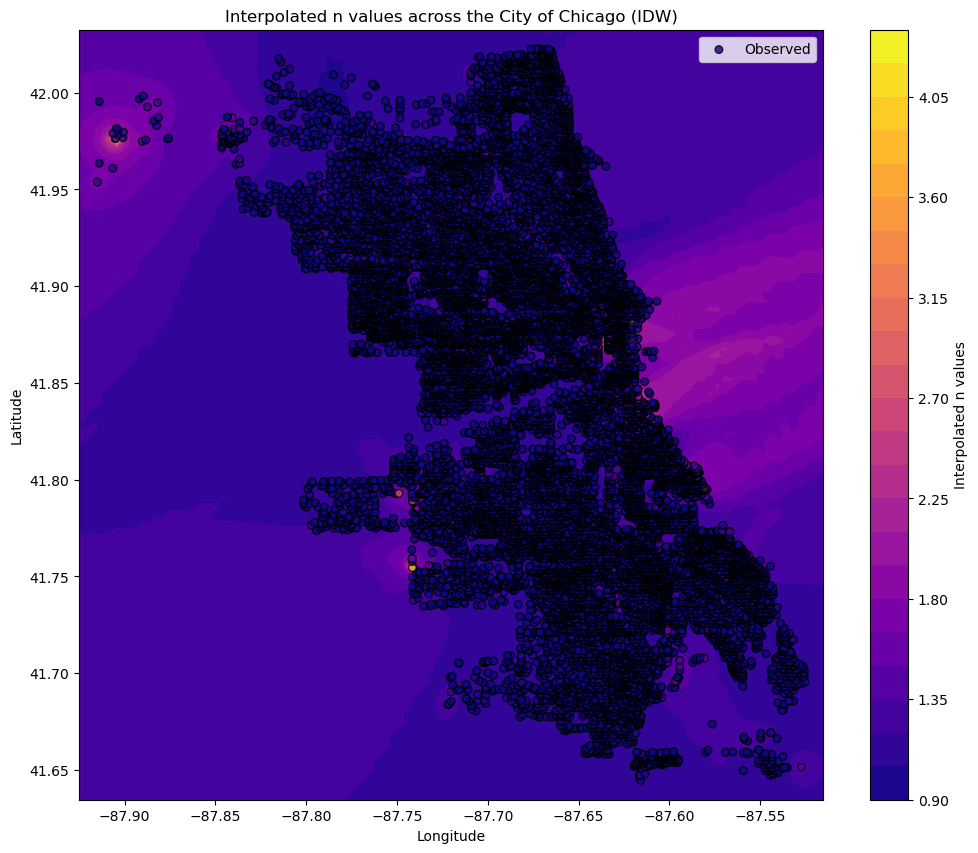

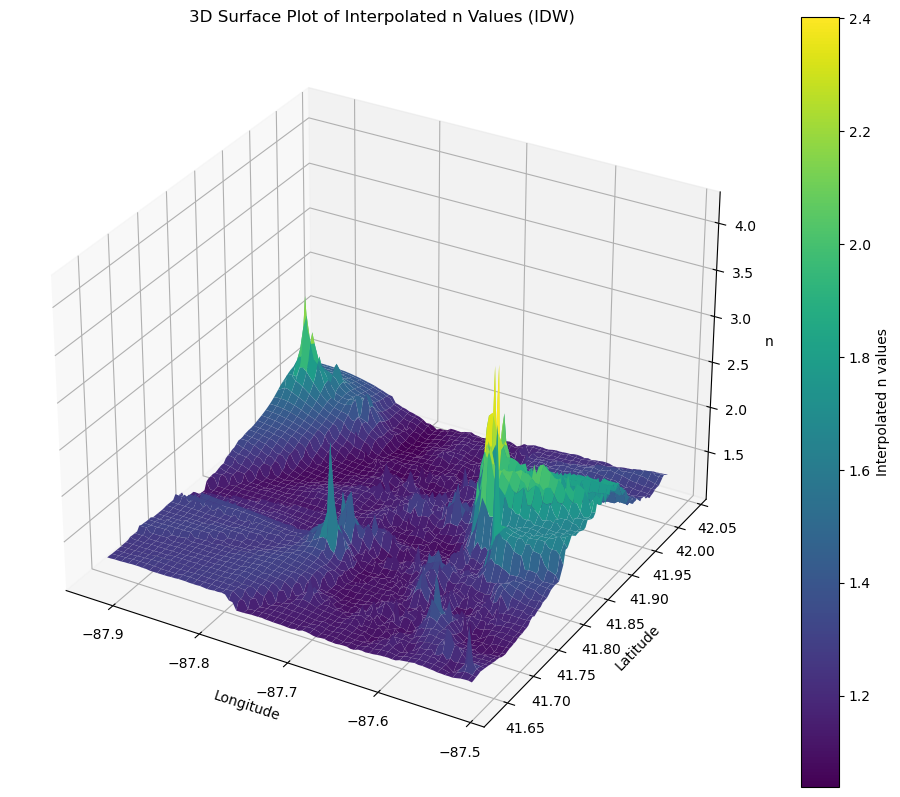

Spatial Interpolation Computation Time: 0.74 seconds


In [80]:
# Using full set: Convert columns to numpy arrays
observed_location_columns_crimes = ['Longitude','Latitude']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations_crimes, observed_values_crimes)

buffer = 0.01
x_min, x_max = observed_locations_crimes[:, 0].min() - buffer, observed_locations_crimes[:, 0].max() + buffer
y_min, y_max = observed_locations_crimes[:, 1].min() - buffer, observed_locations_crimes[:, 1].max() + buffer

x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Start timing spatial interpolation
start_time_interpolation = time.time()

# Interpolate values
#predictions = idw_model.__call__(observed_locations_crimes, power = 1, n_neighbors = 279)
interpolated_values = idw_model.__call__(grid_points, power = 1, n_neighbors = 279)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

fig = plt.figure(figsize=(12, 10))

from mpl_toolkits.mplot3d import Axes3D

plt.contourf(x_grid, y_grid, z_grid, cmap='plasma', levels=30)
plt.colorbar(label='Interpolated n values')
plt.scatter(crimes_df['Longitude'],crimes_df['Latitude'], c=crimes_df['n'], cmap='plasma', edgecolor='k', label='Observed', marker='o', s=30, alpha=0.8)

plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Interpolated n values across the City of Chicago (IDW)')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, label='Interpolated n values')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('n')
ax.set_title('3D Surface Plot of Interpolated n Values (IDW)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

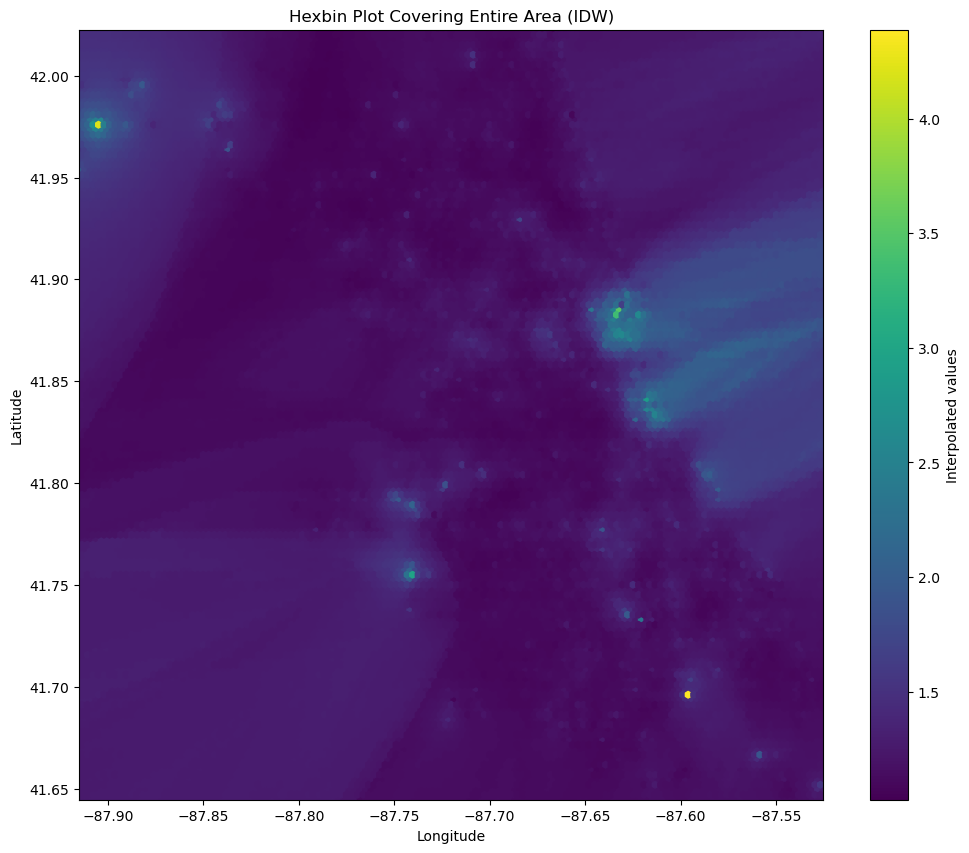

Spatial Interpolation Computation Time: 2.59 seconds


In [84]:
# Determine the minimum and maximum values for Latitude and Longitude
observed_location_columns_crimes = ['Longitude', 'Latitude']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

# Determine the minimum and maximum values for Latitude and Longitude
lat_min, lat_max = crimes_df['Latitude'].min(), crimes_df['Latitude'].max()
lon_min, lon_max = crimes_df['Longitude'].min(), crimes_df['Longitude'].max()

# Generate a mesh grid of latitude and longitude values
grid_size = 200  # Square root of num_points, adjust as needed for resolution
latitude_range = np.linspace(lat_min, lat_max, grid_size)
longitude_range = np.linspace(lon_min, lon_max, grid_size)
lat_grid, lon_grid = np.meshgrid(latitude_range, longitude_range)

# Flatten the grid to create combined array of [latitude, longitude] pairs
combined_array = np.column_stack((lon_grid.ravel(),lat_grid.ravel()))

# Start timing spatial interpolation
start_time_interpolation = time.time()
# Simulate interpolated_values from your IDW model or similar
interpolated_values = idw_model(combined_array, power=1, n_neighbors=279)

end_time_interpolation = time.time()  # End timing spatial interpolation
# Plot using hexbin
plt.figure(figsize=(12, 10))
hb = plt.hexbin(combined_array[:, 0], combined_array[:, 1], C=interpolated_values, gridsize=135, cmap='viridis', extent=(lon_min, lon_max, lat_min, lat_max))
plt.colorbar(hb, label='Interpolated values')

plt.xlim(lon_min, lon_max)  # Corrected for longitude
plt.ylim(lat_min, lat_max)  # Corrected for latitude

plt.xlabel('Longitude')  # Corrected label
plt.ylabel('Latitude')  # Corrected label
plt.title('Hexbin Plot Covering Entire Area (IDW)')
plt.show()
print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

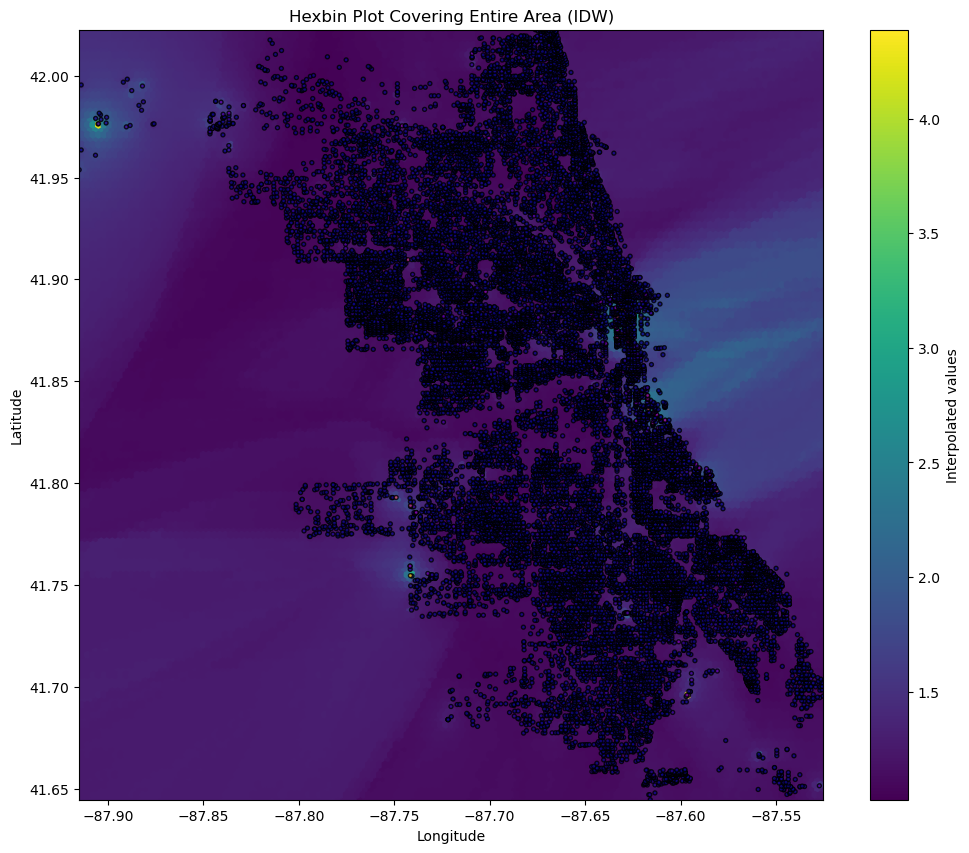

Spatial Interpolation Computation Time: 2.96 seconds


In [86]:
observed_location_columns_crimes = ['Longitude', 'Latitude']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

# Determine the minimum and maximum values for Latitude and Longitude
lat_min, lat_max = crimes_df['Latitude'].min(), crimes_df['Latitude'].max()
lon_min, lon_max = crimes_df['Longitude'].min(), crimes_df['Longitude'].max()

# Generate a mesh grid of latitude and longitude values
grid_size = 200  # Square root of num_points, adjust as needed for resolution
latitude_range = np.linspace(lat_min, lat_max, grid_size)
longitude_range = np.linspace(lon_min, lon_max, grid_size)
lat_grid, lon_grid = np.meshgrid(latitude_range, longitude_range)

# Flatten the grid to create combined array of [latitude, longitude] pairs
combined_array = np.column_stack((lon_grid.ravel(),lat_grid.ravel()))

# Start timing spatial interpolation
start_time_interpolation = time.time()
# Simulate interpolated_values from your IDW model or similar
interpolated_values = idw_model(combined_array, power=1, n_neighbors=279)

end_time_interpolation = time.time()  # End timing spatial interpolation
# Plot using hexbin
plt.figure(figsize=(12, 10))
hb = plt.hexbin(combined_array[:, 0], combined_array[:, 1], C=interpolated_values, gridsize=135, cmap='viridis', extent=(lon_min, lon_max, lat_min, lat_max))
plt.scatter(crimes_df['Longitude'], crimes_df['Latitude'], c=crimes_df['n'], cmap='plasma', edgecolor='k', label='Observed', marker='o', s= 8, alpha=0.8)
plt.colorbar(hb, label='Interpolated values')

plt.xlim(lon_min, lon_max)  # Corrected for longitude
plt.ylim(lat_min, lat_max)  # Corrected for latitude

plt.xlabel('Longitude')  # Corrected label
plt.ylabel('Latitude')  # Corrected label
plt.title('Hexbin Plot Covering Entire Area (IDW)')
plt.show()
print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")